**Author:** Vinícius Antoino Ramos Zecca

**Email:** btvarz@gmail.com / wrt.varz@gmail.com

**LinkedIn:** /viniciusarz

**Github:** /ViniciusARZ

In [ ]:
## Usual Stack
!pip install -q --upgrade gspread
!pip install -q pandas==1.2.4
!pip install -q -U -q PyDrive
!pip install -q datetime
!pip install -q pendulum
!pip install -q matplotlib
!pip install -q seaborn
!pip install xlrd==1.2.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
import pendulum

In [3]:
df = pd.read_excel("/content/Sample_-_Superstore.xls")
df.head(3)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


Observando os dtypes e a distribuição de informações do dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9983 non-null   float64       
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

*As perguntas não estão em ordem de pedido, mas na ordem em que fui raciocinando e executando a análise exploratória.*

In [127]:
# Dataframe com o ultimo ano do dataset para exploratória
df_lasty = df[df['Order Date']>'2018-01-01'].sort_values('Order Date')

# Dataframe com o ultimo trimestre do dataset para exploratória
df_lastq = df[df['Order Date']>'2018-10-01'].sort_values('Order Date')

## 2 - Há algum mês em que as vendas são melhores?


Para observar o mês em que as vendas são melhores, é interessante uma análise exploratória das variáveis relacionadas a indicadores de vendas

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text major ticklabel objects>)

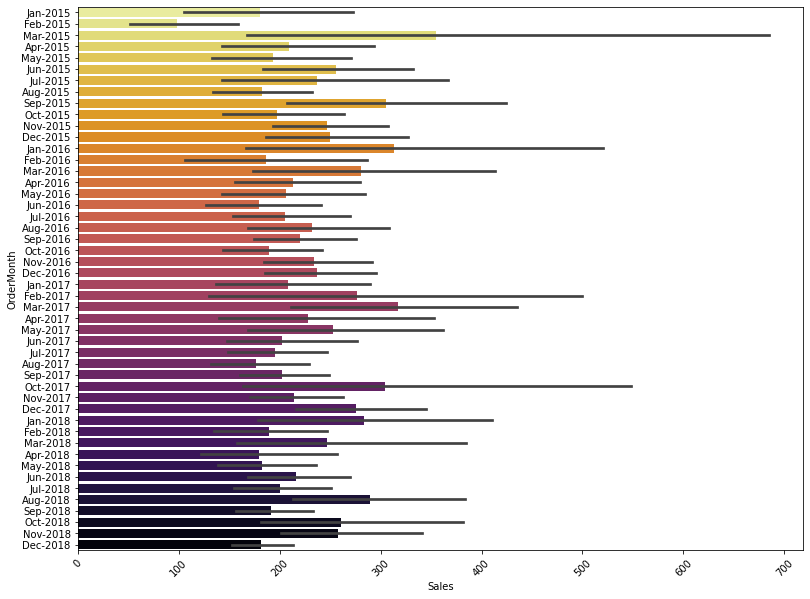

In [142]:
plt.figure(figsize=(13,10))
sns.barplot('Sales','OrderMonth',data=df.sort_values('Order Date'),palette="inferno_r")
plt.xticks(rotation=45)

Por aqui é visível que Março-2015 foi o mês com maior valor de venda, porém o que me preocupa é a error bar com uma variância muito grande, então acredito ser interessante observar o comportamento do lucro e desconto pois podem demonstrar o comportamento de produtos de menor valor agregado sendo vendidos ou então descontos muito altos que explicariam a variância grande.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([-200., -150., -100.,  -50.,    0.,   50.,  100.,  150.,  200.,
         250.]), <a list of 10 Text major ticklabel objects>)

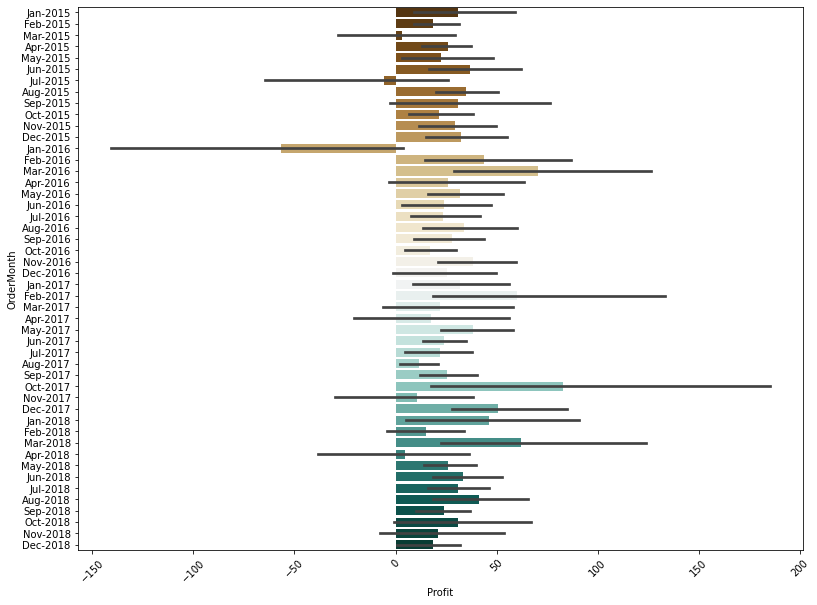

In [143]:
plt.figure(figsize=(13,10))
sns.barplot('Profit','OrderMonth',data=df.sort_values('Order Date'),palette="BrBG")
plt.xticks(rotation=45)

Aqui pode-se observar uma das minhas preocupações, visto que o lucro no mesmo mês foi extremamente baixo quando observa-se o dataset inteiro. Isso *pode* significar que o custo dos produtos daquele mês são altos demais ou então que muitos descontos foram aplicados.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 <a list of 7 Text major ticklabel objects>)

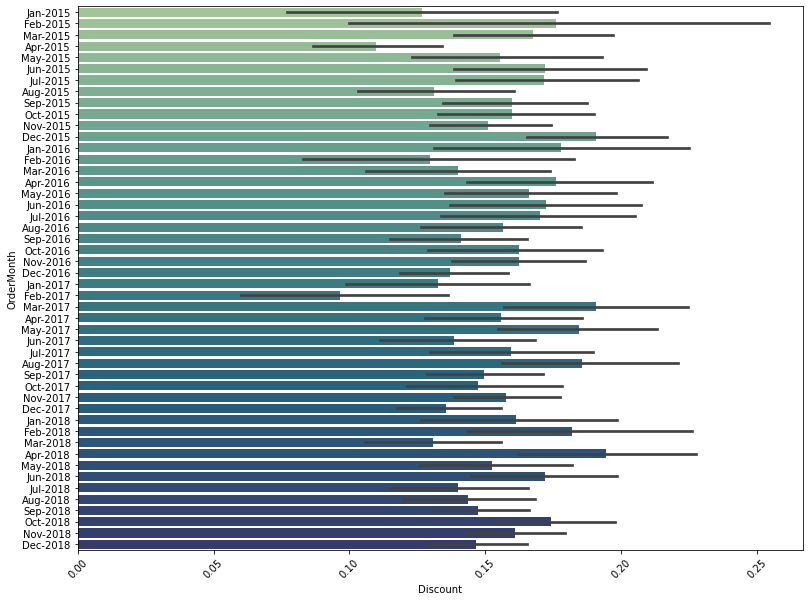

In [144]:
plt.figure(figsize=(13,10))
sns.barplot('Discount','OrderMonth',data=df.sort_values('Order Date'),palette="crest")
plt.xticks(rotation=45)

O desconto não parece ser a justificativa maior, então acredito que seja mesmo a margem de lucro dos produtos mais vendidos naquele mês.

O que pode ser dito em resposta à pergunta é:
1. O mês com o maior valor de venda foi Março-2015, porém isso não significa que foi o melhor.
2. Se considerarmos "melhor" como o lucro sob o volume de vendas, o melhor mês seria Outubro de 2017.

Mas eu acredito que a melhor forma seria a empresa ter um KPI que calcule a relação do lucro com descontos e valor de venda de acordo com o planejamento estratégico. Exemplo, caso a empresa busque crescimento de marca talvez o valor de vendas, mesmo que com maior desconto, seja mais interessante do que uma grande margem de lucro. Agora, caso ela esteja em fase de investimento interno e busque maior arrecadação, é melhor que sua margem de lucro seja maior em detrimento da quantidade. Por isso fica dificil afirmar qual foi o melhor mês, acredito que o "melhor" depende do objetivo geral da organização.

## 3. Quais são os produtos mais vendidos e qual o preço de custo deles?

Calculando o preço de custo dos produtos e agrupamento com preço de custo.

In [125]:
def prod_cost(df,value,profit,quantity):
  v = df[value]
  p = df[profit]
  q = df[quantity]
  return (v-p).sum()/q.sum()

product_group = df[['Product Name','Sales','Profit','Quantity']].groupby('Product Name').apply(prod_cost,'Sales','Profit','Quantity').sort_values(ascending=False)
product_group.head(5)

Product Name
Cisco TelePresence System EX90 Videoconferencing Unit    4074.9264
Cubify CubeX 3D Printer Triple Head Print                2959.9926
Cubify CubeX 3D Printer Double Head Print                2219.9926
Canon imageCLASS 2200 Advanced Copier                    1819.9948
High Speed Automatic Electric Letter Opener              1572.0288
dtype: float64

Agora observando o mesmo cálculo porém junto às métricas de vendas, lucro e quantidade. Assim pode-se observar quais são os produtos mais vendidos através de um ordenamento por número de unidades vendidas no total com seu preço de custo e lucro ao lado.

In [126]:
products_df = df[['Product Name','Sales','Profit','Quantity']].groupby('Product Name').sum().reset_index()
products_df['CostPerProduct'] = (products_df['Sales']-products_df['Profit'])/products_df['Quantity']
products_df.sort_values('Quantity',ascending=False).head(10)

,Product Name,Sales,Profit,Quantity,CostPerProduct
1499,Staples,755.470,292.2046,215,2.154723
1493,Staple envelope,1686.812,751.6290,170,5.501076
537,Easy-staple paper,2504.192,1096.0292,150,9.387752
1500,Staples in misc. colors,478.812,124.0516,86,4.125121
942,KI Adjustable-Height Table,4552.641,-248.4822,74,64.880043
259,Avery Non-Stick Binders,217.316,43.5530,71,2.447366
1511,Storex Dura Pro Binders,278.586,50.5494,71,3.211783
699,GBC Premium Transparent Covers with Diagonal L...,780.456,49.5128,67,10.909600
1450,"Situations Contoured Folding Chairs, 4/Set",3641.274,234.2340,64,53.235000
1497,Staple-based wall hangings,422.288,121.9936,62,4.843458


Assim pode-se dizer que os produtos mais vendidos em quantidade foram os acima, liderados por Grampos e produtos com preço de custo baixo.

## 4 - Avalie se há correlação entre tipo de entrega e o valor das ordens

Análise exploratória para chegar a uma resposta

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

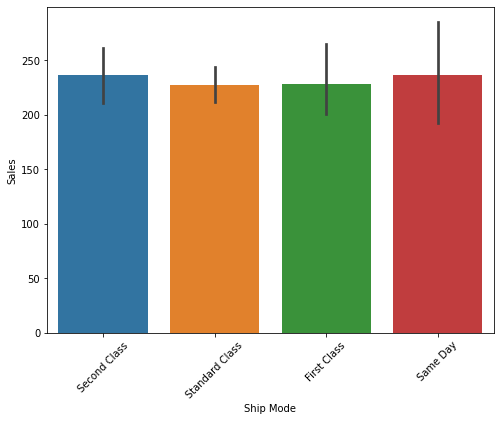

In [153]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x="Ship Mode", y="Sales", data=df)
plt.xticks(rotation=45)

Observando os valores gerais, pode-se dizer que não há grande correlação entre os tipos de entrega (Ship Mode) e o valor dos pedidos. Porém vale a pena observar outras medidas do valor, como lucro.

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

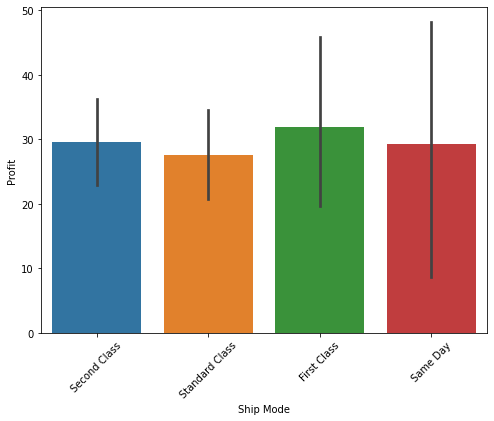

In [154]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x="Ship Mode", y="Profit", data=df)
plt.xticks(rotation=45)

Apesar de *First Class* se sobressair um pouco no dataset total em termos de lucro, não acredito que seja uma correlação direta com o valor de venda. Por isso, acredito ser importante observar como essa relação se dá com o tempo pois é possível que existam modos de entrega com maior distinção em certos períodos.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

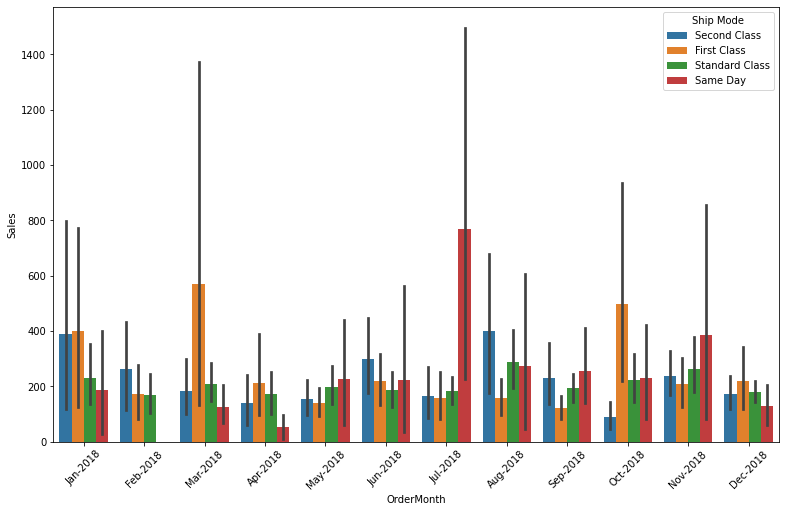

In [156]:
plt.figure(figsize=(13,8))
ax = sns.barplot(x="OrderMonth", y="Sales", hue="Ship Mode", data=df_lasty)
plt.xticks(rotation=45)

Observando 2018, o ano mais recente do dataset, pode-se observar como algumas modalidades de entrega se sobressaem periodicamente. Assim, eu diria que não existe uma relação significamente relevante observando o periodo todo, mas existem meses que, provavelmente por causa de ações internas da loja ou períodos de mercado, possuem relações sobrevalentes de certas modalidades com um alto valor de venda.

## 1 - Quais seriam as suas recomendações para aumentar o lucro desta loja?

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

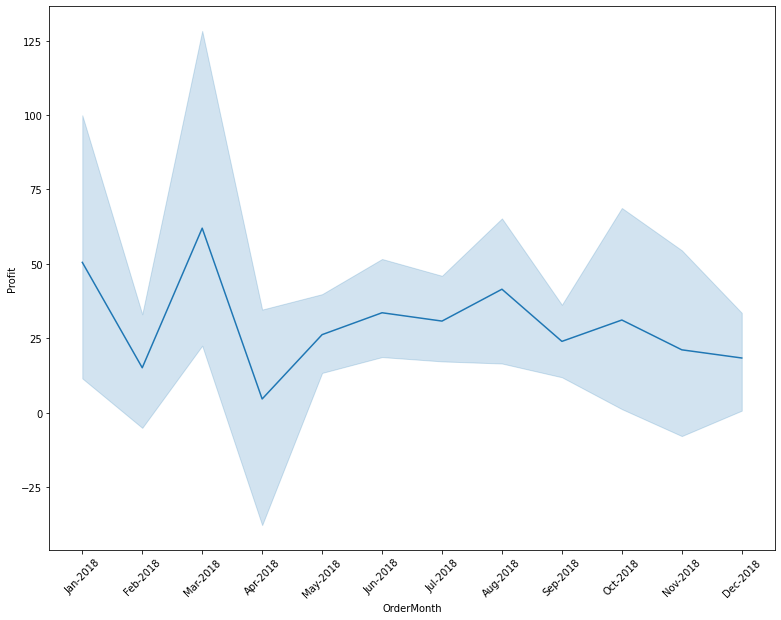

In [128]:
def get_month_year(x):
  return dt.datetime(x.year,x.month,1).strftime('%b-%Y')
df['OrderMonth'] = df['Order Date'].apply(get_month_year)
plt.figure(figsize=(13,10))
ax = sns.lineplot(x="OrderMonth", y="Profit", data=df_lasty)
plt.xticks(rotation=45)

Observando a distribuição do lucro por 2018, dividido por mês e relembrando da análise exploratória feita na pergunta 2, não é possível prescrever recomendações apenas com base no período. Vale a pena observar a correlação entre as medidas numéricas que envolvem o lucro, como por exemplo o valor de venda, a quantidade e o desconto dado.

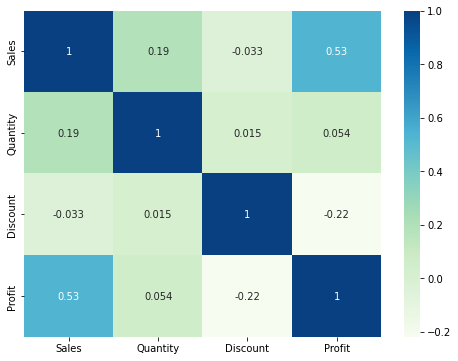

In [150]:
corr = df_lasty[['Sales','Quantity','Discount','Profit']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='GnBu')

A correlação demonstra caracteristicas de relação direta e indireta previsíveis, como quanto maior o desconto menor o lucro, porém isso será guardado para abordagem posterior. Vale a pena observar a segmentação por atributos categóricos do dataset, agora delimitando mais ao ultimo trimestre por sua maior representação com a realidade atual do mercado.

In [134]:
df_lastq.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'OrderMonth',
       'CostPerProduct'],
      dtype='object')

Lucro mensal por região

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

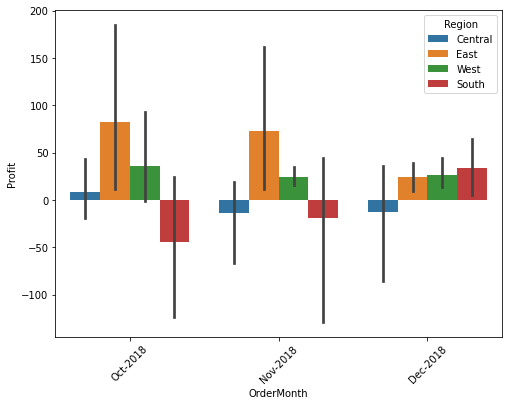

In [147]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x="OrderMonth", y="Profit", hue="Region", data=df_lastq)
plt.xticks(rotation=45)

Lucro mensal por Segmento de Venda

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

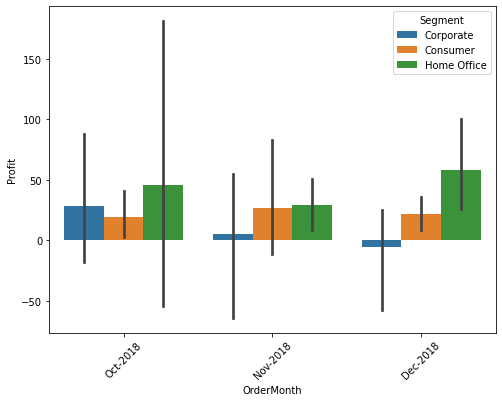

In [148]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x="OrderMonth", y="Profit", hue="Segment", data=df_lastq)
plt.xticks(rotation=45)

Lucro mensal por Categoria

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

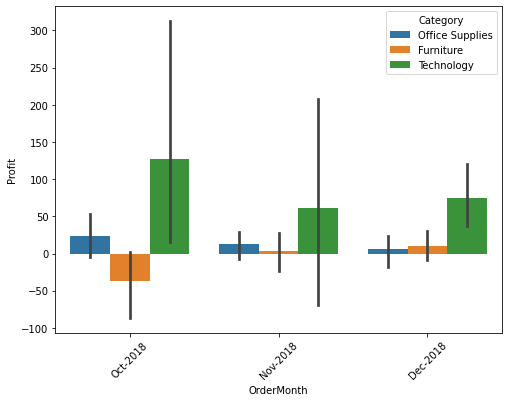

In [149]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x="OrderMonth", y="Profit", hue="Category", data=df_lastq)
plt.xticks(rotation=45)

Lucro Mensal por Sub-Categoria

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

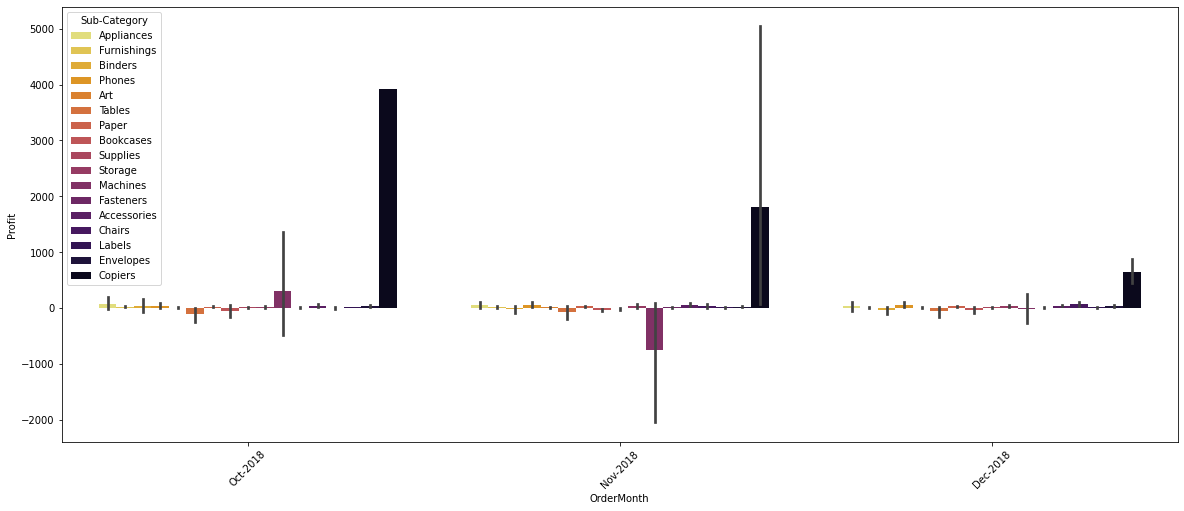

In [158]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x="OrderMonth", y="Profit", hue="Sub-Category", data=df_lastq,palette="inferno_r")
plt.xticks(rotation=45)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

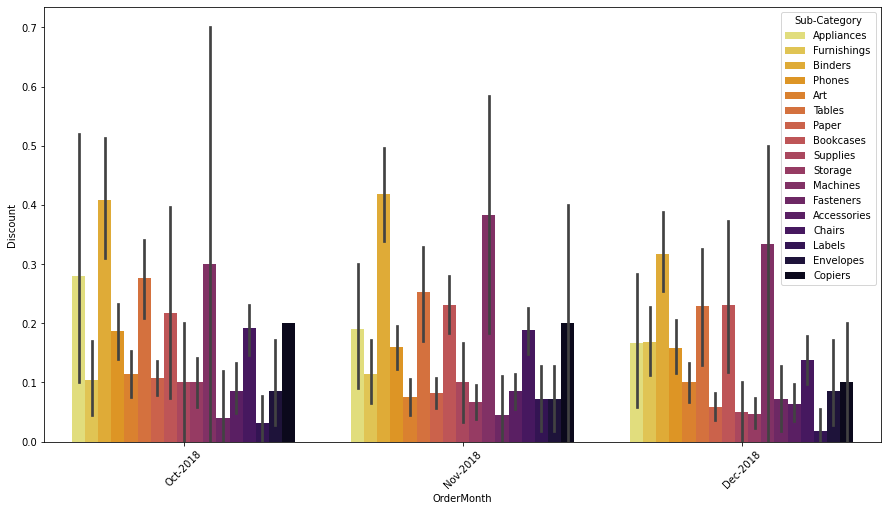

In [159]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="OrderMonth", y="Discount", hue="Sub-Category", data=df_lastq,palette="inferno_r")
plt.xticks(rotation=45)

Observando o último trimestre do dataset e a distribuição do lucro pelas variáveis categóricas mais abrangentes, pode-se dizer que a **maior fonte de lucro está em geral nas regiões Leste e Oeste dos Estados Unidos, com foco nos segmentos de Consumo e Home Office de produtos de tecnologia**. Ao falar de subcategorais é mais abrangente, porém a maior dominação no quesito lucro é na sub categoria de copiadoras (Copiers), com controvérsias na categoria de acessórios (Acessories) que obteve lucro maior que a maioria em Outubro, mas causou prejuízo em Novembro, o que pode ser justificado observando a barra de erro com grande variância nos descontos dados para produtos dessa sub categoria no mesmo mês. 

Agora, ao considerar as características gerais apresentadas e observar a correlação dos valores como se fosse um Ideal Customer Profile, pode-se observar.

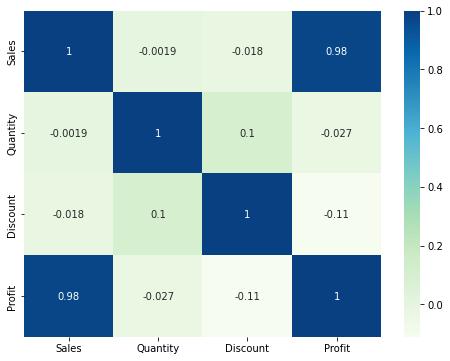

In [152]:
icp = df_lastq[(df_lastq['Region'].isin(['East','West'])) & df_lastq['Segment'].isin(['Consumer','Home Office']) & (df_lastq['Category'] == "Technology")]
corr = icp[['Sales','Quantity','Discount','Profit']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='GnBu')

Diferente da matriz de correlação considerando o dataset inteiro, a relação de lucro com valor de vendas aqui é muito maior, ao mesmo tempo a relação com a quantidade é quase insignificante. O que pode indicar que a margem de lucro dos produtos que se enquadram nesse público é maior e que é mais importante para gerar mais lucro (nesse ICP) a venda de produtos de maior valor agregado do que a venda de produtos em maior quantidade mas com menor margem de lucro.
Assim, eu recomendaria para a empresa o foco em ICPs segmentados, sendo este um exemplo deles, com diferentes critérios para decisão de promoções ou descontos. Isso porque nesse caso  pode-se observar que o desconto tem uma relação inversa de 0.11 com o lucro, ou seja, ao comparar com o dataset inteiro é menos prejudicial para o lucro total dar descontos nesse ICP do que em outros.
A recomendação não necessariamente seria focar suas vendas nessa delimitação de ICP, porque isso causaria uma diminuição no tamanho de mercado atingível, mas sim que a empresa executasse constantemente revisões em diferentes clusters de consumidor e adequasse suas lojas às proporções em que eles aparecem em cada uma delas.